# 4. Sentiment Analysis strategy implementation

## CFR-OGD-SA

## CFR-ONS-SA

## Utils

In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [27]:

    
def convert_prices(date0, date1, period, decay):
    start_date = datetime.strptime(date0, '%Y-%m-%d')
    end_date = datetime.strptime(date1, '%Y-%m-%d') + timedelta(days=decay, hours=23, minutes = 59, seconds=59)
    df = pd.read_csv('Data/Testing_data/Prices/data_' + period + '.csv')
    df['Gmt time'] = pd.to_datetime(df['Gmt time'])
    df.head(2)
    mask = (df['Gmt time'] > start_date) & (df['Gmt time'] <= end_date)
    df_fin = df.loc[mask]
    df_fin = df_fin.reset_index(drop=True)
    df_fin_date = np.array(df_fin['Gmt time'])
    df_fin_price = np.array(df_fin[['EURUSD', 'CADUSD', 'GBPUSD', 'JPYUSD']])
    df_fin_date
    close_prices = []
    if period == 'm':
        hours = 0
        minutes = 0
    elif period == 'h':
        hours = 0
        minutes = 59
    elif period == 'd':
        hours = 1
        minutes = 59
    for i in range(1, (end_date - start_date).days+2):
        day_analyzed_end = start_date + timedelta(hours=24)*i - timedelta(hours=hours, 
                                                                          minutes=minutes, 
                                                                          seconds=60)
        if day_analyzed_end >= datetime.strptime('2019-03-10', '%Y-%m-%d'):
            day_analyzed_end = day_analyzed_end - timedelta(hours=1)
        mask_close_pr = (df_fin['Gmt time'] == day_analyzed_end)
        close_pr = df_fin.loc[mask_close_pr]
        close_pr = close_pr.reset_index(drop=True)
        close_prices.append(np.array(close_pr[['EURUSD', 'CADUSD', 'GBPUSD', 'JPYUSD', 'Gmt time']]))
    prices_ok = []
    prices_ok_eur = []
    prices_ok_cad = []
    prices_ok_gbp = []
    prices_ok_jpy = []
    for i in range(len(df_fin_date)):
        price_ed = np.array([df_fin_price[i,:], df_fin_date[i]])
        price_eur = np.array([df_fin_price[i,0], df_fin_date[i]])
        price_cad = np.array([df_fin_price[i,1], df_fin_date[i]])
        price_gbp = np.array([df_fin_price[i,2], df_fin_date[i]])
        price_jpy = np.array([df_fin_price[i,3], df_fin_date[i]])
        prices_ok.append(price_ed)
        prices_ok_eur.append(price_eur)
        prices_ok_cad.append(price_cad)
        prices_ok_gbp.append(price_gbp)
        prices_ok_jpy.append(price_jpy)
    return prices_ok, close_prices, prices_ok_eur, prices_ok_cad, prices_ok_gbp, prices_ok_jpy

def convert_sentiment(curr_pair, date0, date1):
    start_date = datetime.strptime(date0, '%Y-%m-%d') 
    end_date = datetime.strptime(date1, '%Y-%m-%d') + timedelta(days=0, hours=23, minutes = 59, seconds=59)
    df = pd.read_csv('Data/Classification_data/' + curr_pair + '/CascadingTests/' + curr_pair + 'output.csv', header=None)
    df[5] = pd.to_datetime(df[5])
    mask = (df[5] > start_date) & (df[5] <= end_date)
    df_fin = df.loc[mask]
    df_fin = df_fin.reset_index(drop=True)
    df_fin = df_fin.iloc[::-1]
    sent_all_pd = []
    cum_sent = []
    start_days = []
    for i in range(1, (end_date - start_date).days+2):
        if i == 1:
            day_analyzed_start = start_date
        else:
            day_analyzed_start = day_analyzed_end + timedelta(seconds=1)
        day_analyzed_end = start_date + timedelta(hours=24)*i - timedelta(seconds=1)
        start_days.append(day_analyzed_start)
        sent_mask = (df_fin[5] >= day_analyzed_start) & (df_fin[5] <= day_analyzed_end)
        sent_day_data = df_fin.loc[sent_mask]
        sent_day_data = sent_day_data.reset_index(drop=True)
        sent_ok = []
        cum_sent_day = 0
        for i in range(sent_day_data.shape[0]):
            if sent_day_data[3][i][0] == '0':
                classif = 0
            elif sent_day_data[3][i][0] == '-':
                classif = -1
            elif sent_day_data[3][i][0] == '1':
                classif = 1
            sent_ed = np.array([classif, sent_day_data[5][i]])
            cum_sent_day += sent_ed[0] 
            sent_ok.append(sent_ed)
        cum_sent.append(cum_sent_day)
        for i in range(1, len(sent_ok)):
            sent_ok[i][0] += sent_ok[i-1][0]
        sent_all_pd.append(pd.DataFrame(sent_ok))
    sent_all_pd = pd.concat(sent_all_pd, axis=0)
    return cum_sent, sent_all_pd, start_days

In [18]:
def sentiment_strategy(date0, date1, period, decay):
    
    def sentiment_strategy_run(pairname, date0, date1, period, decay):
        
        threshold = 50
        if pairname == 'EURUSD':
            column = 0
        elif pairname == 'CADUSD':
            column = 1
        elif pairname == 'GBPUSD':
            column = 2
        elif pairname == 'JPYUSD':
            column = 3
            
        prices_data = convert_prices(date0, date1, period, decay)
        sent_data = convert_sentiment(pairname, date0, date1)
        diff_days = len(prices_data[1]) - len(sent_data[2])
        print('Difference in days b/t pr and sent = {} \n'.format(diff_days))
        
        signals = []
        for i in range(len(sent_data[0])):
            if sent_data[0][i] > 0 and sent_data[0][i] >= threshold:
                signal = -1.0
            elif sent_data[0][i] >= 0 and sent_data[0][i] < threshold:
                signal = 0.0
            elif sent_data[0][i] < 0:
                signal = 1.0
            signals.append(signal)
            
        trading_data = pd.concat([pd.DataFrame(np.array(prices_data[1])[:,0][:,4], columns=['date']), 
                                  pd.DataFrame(sent_data[0], columns=['day_sent']), 
                                  pd.DataFrame(np.array(prices_data[1])[:,0][:,column], columns=[pairname]),
                                  pd.DataFrame(signals, columns=['trading_signal'])],
                                 axis=1)
        
        n_buys = (pd.DataFrame(signals)[0] == 1.0).sum()
        n_sells = (pd.DataFrame(signals)[0] == -1.0).sum()
        n_holds = (pd.DataFrame(signals)[0] == 0.0).sum()
        print('Number of long positions = {}'.format(n_buys))
        print('Number of short positions = {}'.format(n_sells))
        print('Number of "do nothing" positions = {}\n'.format(n_holds))
        
        delta = n_buys - n_sells
        if delta > 0:
            print('We need to SELL such a number of {} in order to close position: {}'.format(pairname[:3] ,abs(delta)))
        elif delta < 0:
            print('We need to BUY such a number of {} in order to close position: {}'.format(pairname[:3] ,abs(delta)))
        elif delta == 0:
            print('Do nothing. Our delta is : {}'.format(abs(delta)))
        
        trading_data_np = np.array(trading_data)
        daily_pl = []
        daily_pl_cum = []
        for i in range(trading_data_np.shape[0]-diff_days):
            pl = -trading_data_np[i][2] * trading_data_np[i][3]
            daily_pl.append(pl)
            daily_pl_cum.append(pl)
        for i in range(1, len(daily_pl_cum)):
            daily_pl_cum[i] += daily_pl_cum[i-1]

        init_inv = []
        init_inv.append(0)
        for i in range(1,len(daily_pl_cum)):
            if np.array(daily_pl_cum[:i]).min() >= 0:
                inv = 0
            else:
                inv = -np.array(daily_pl_cum[:i]).min()
            init_inv.append(inv)

        daily_pl_graph = []
        for i in range(len(init_inv)):
#             if init_inv[i] == 0:
#                 pl_gr = daily_pl[i]
#             else:
            pl_gr = daily_pl[i]
            daily_pl_graph.append(pl_gr)

        cum_pl_graph = daily_pl_graph.copy()
        for i in range(1, len(cum_pl_graph)):
            cum_pl_graph[i] += cum_pl_graph[i-1]

        pl_intra = np.array(daily_pl).sum()
        days_av_to_close = 2
        end = np.array(np.array(prices_data[1])[:,0][:,column])[len(np.array(prices_data[1])[:,0][:,column])-days_av_to_close:len(np.array(prices_data[1])[:,0][:,column])-1].mean()
        pl_final = delta*end + pl_intra

        for i in range(diff_days-1):
            cum_pl_graph.append(0)
        for i in range(diff_days - days_av_to_close):
            daily_pl_graph.append(0)
        for i in range(days_av_to_close):
            daily_pl_graph.append((delta*end)/days_av_to_close)
        cum_pl_graph.append(pl_final)
        trading_data = pd.concat([pd.DataFrame(np.array(prices_data[1])[:,0][:,4], columns=['date']), 
                                  pd.DataFrame(sent_data[0], columns=['day_sent']), 
                                  pd.DataFrame(np.array(prices_data[1])[:,0][:,column], columns=['close_price']),
                                  pd.DataFrame(signals, columns=['trading_signal']),
                                  pd.DataFrame(daily_pl, columns=['daily_pl']),
                                 pd.DataFrame(daily_pl_cum, columns=['cum_pl']),
                                    pd.DataFrame(init_inv, columns=['init_inv']),
                                 pd.DataFrame(daily_pl_graph, columns=['daily_return_graph']),
                                 pd.DataFrame(cum_pl_graph, columns=['cum_return_graph'])],
                                 axis=1)
        if trading_data['cum_pl'].min() >= 0:
            initial_investment = 1
        else:
            initial_investment = -trading_data['cum_pl'].min()
        cum_ret = (pl_final) / initial_investment
        
        return trading_data
    
    results = {}
    print('EURUSD')
    results['EURUSD'] = sentiment_strategy_run('EURUSD', date0, date1, period, decay)
    print('GBPUSD')
    results['GBPUSD'] = sentiment_strategy_run('GBPUSD', date0, date1, period, decay)
    print('CADUSD')
    results['CADUSD'] = sentiment_strategy_run('CADUSD', date0, date1, period, decay)
    print('JPYUSD')
    results['JPYUSD'] = sentiment_strategy_run('JPYUSD', date0, date1, period, decay)
    
    return results


def basics_run(strategy, period, date0, date1, n_restarts, decay):
    rfr = 2.3/100
    cumul_results = {}
    start_date = datetime.strptime(date0, '%Y-%m-%d')
    end_date = datetime.strptime(date1, '%Y-%m-%d') + timedelta(days=0, hours=23, minutes = 59, seconds=59)
    tc = 0.
    opts = {'display_interval': 1000}
    
    # Prices
    df = pd.read_csv('Data/Testing_data/Prices/data_' + period + '_ret.csv')
    df['Gmt time'] = pd.to_datetime(df['Gmt time'])
    mask = (df['Gmt time'] > start_date) & (df['Gmt time'] <= end_date)
    df_fin = df.loc[mask]
    df_fin = df_fin.reset_index(drop=True)
    df_fin_np = np.array(df_fin.drop(['Gmt time'], axis=1))
    df_fin_np_time = np.array(df_fin)
    df_fin_date = np.array(df_fin[['Gmt time']])
    day_range = (end_date - start_date).days + 1
    
#     if strategy == 'CFR-OGD-SA':
#         results = cfr_ogd_sa(df_fin_np, df_fin_np_time, period, tc, opts)
#     elif strategy == 'CFR-ONS-SA':
#         results = cfr_ons_sa(df_fin_np, df_fin_np_time, period, tc, opts)
    if strategy == 'Sent_Analysis':
        results = sentiment_strategy(date0, date1, period, decay)
        
    return results

In [36]:
from datetime import datetime, timedelta 
import pandas as pd
import numpy as np
from tqdm import tnrange

strategy = 'Sent_Analysis'
curr_pair = 'EUR, GBP, JPY, CAD hourly'
date0 = '2019-03-21'
date1 = '2019-03-25'
n_restarts = 1
# Frequency: daily (d), hourly (h), minutely (m)
period = 'h' 
# DECAY = number of days b/t sentiment and prices (lag b/t sentiment and prices reaction)
decay = 4
res = basics_run(strategy, period,  date0, date1, n_restarts, decay) # returns a dictionary

EURUSD
Difference in days b/t pr and sent = 4 

Number of long positions = 2
Number of short positions = 1
Number of "do nothing" positions = 2

We need to SELL such a number of EUR in order to close position: 1
GBPUSD
Difference in days b/t pr and sent = 4 

Number of long positions = 1
Number of short positions = 1
Number of "do nothing" positions = 3

Do nothing. Our delta is : 0
CADUSD
Difference in days b/t pr and sent = 4 

Number of long positions = 0
Number of short positions = 0
Number of "do nothing" positions = 5

Do nothing. Our delta is : 0
JPYUSD
Difference in days b/t pr and sent = 4 

Number of long positions = 2
Number of short positions = 1
Number of "do nothing" positions = 2

We need to SELL such a number of JPY in order to close position: 1


In [37]:
res['EURUSD']

,date,day_sent,close_price,trading_signal,daily_pl,cum_pl,init_inv,daily_return_graph,cum_return_graph
0,2019-03-21 22:00:00,90.0,1.13763,-1.0,1.13763,1.13763,0.0,1.137630,1.13763
1,2019-03-22 22:00:00,-10.0,1.13004,1.0,-1.13004,0.00759,0.0,-1.130040,0.00759
2,2019-03-23 22:00:00,0.0,1.13004,0.0,-0.00000,0.00759,0.0,-0.000000,0.00759
3,2019-03-24 22:00:00,30.0,1.12955,0.0,-0.00000,0.00759,0.0,-0.000000,0.00759
4,2019-03-25 22:00:00,-45.0,1.13143,1.0,-1.13143,-1.12384,0.0,-1.131430,-1.12384
5,2019-03-26 22:00:00,NaN,1.12753,NaN,NaN,NaN,NaN,0.000000,0.00000
6,2019-03-27 22:00:00,NaN,1.12491,NaN,NaN,NaN,NaN,0.000000,0.00000
7,2019-03-28 22:00:00,NaN,1.12281,NaN,NaN,NaN,NaN,0.561405,0.00000
8,2019-03-29 22:00:00,NaN,1.12179,NaN,NaN,NaN,NaN,0.561405,-0.00103


In [38]:
res['GBPUSD']

,date,day_sent,close_price,trading_signal,daily_pl,cum_pl,init_inv,daily_return_graph,cum_return_graph
0,2019-03-21 22:00:00,142.0,1.31219,-1.0,1.31219,1.31219,0.00000,1.31219,1.31219
1,2019-03-22 22:00:00,-12.0,1.32058,1.0,-1.32058,-0.00839,0.00000,-1.32058,-0.00839
2,2019-03-23 22:00:00,0.0,1.32058,0.0,-0.00000,-0.00839,0.00839,-0.00000,-0.00839
3,2019-03-24 22:00:00,10.0,1.32098,0.0,-0.00000,-0.00839,0.00839,-0.00000,-0.00839
4,2019-03-25 22:00:00,9.0,1.32085,0.0,-0.00000,-0.00839,0.00839,-0.00000,-0.00839
5,2019-03-26 22:00:00,NaN,1.32069,NaN,NaN,NaN,NaN,0.00000,0.00000
6,2019-03-27 22:00:00,NaN,1.3153,NaN,NaN,NaN,NaN,0.00000,0.00000
7,2019-03-28 22:00:00,NaN,1.3055,NaN,NaN,NaN,NaN,0.00000,0.00000
8,2019-03-29 22:00:00,NaN,1.30294,NaN,NaN,NaN,NaN,0.00000,-0.00839


In [39]:
def sent_plot(np_sentiment_data, np_price_data, pair):
    if pair == 'EURUSD':
        color = '#00CED1'
    elif pair == 'CADUSD':
        color = '#000080'
    elif pair == 'GBPUSD':
        color = '#FFA500'
    elif pair == 'JPYUSD':
        color = '#C71585'
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot_date(np.array(np_sentiment_data[1])[:,1], np.array(np_sentiment_data[1])[:,0], 
                 '-', c='#008000', label = 'Daily Sentiment for {}'.format(pair), linewidth=3)
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.tick_params(axis='x', which='major', labelsize=10) #, rotation=90)
    ax.legend(loc='upper left', prop={'size':10})
    ax2 = ax.twinx()
    ax2.plot(np.array(np_price_data)[:,1], np.array(np_price_data)[:,0], '-', c=color,
            label = 'Exchange rate for {}'.format(pair), linewidth=3)
    ax2.tick_params(axis='y', which='major', labelsize=10)
    ax2.tick_params(axis='x', which='major', labelsize=10) #, rotation=90)
    ax2.legend(loc='upper right', prop={'size':10})
    ax.autoscale_view()
    ax.grid(True)

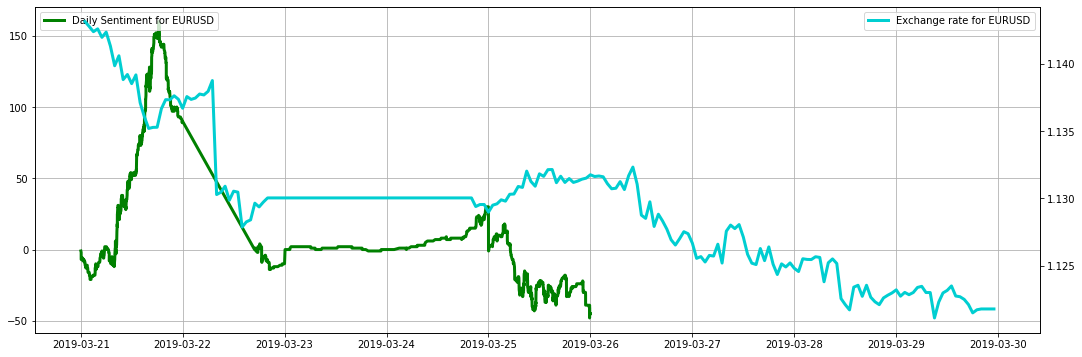

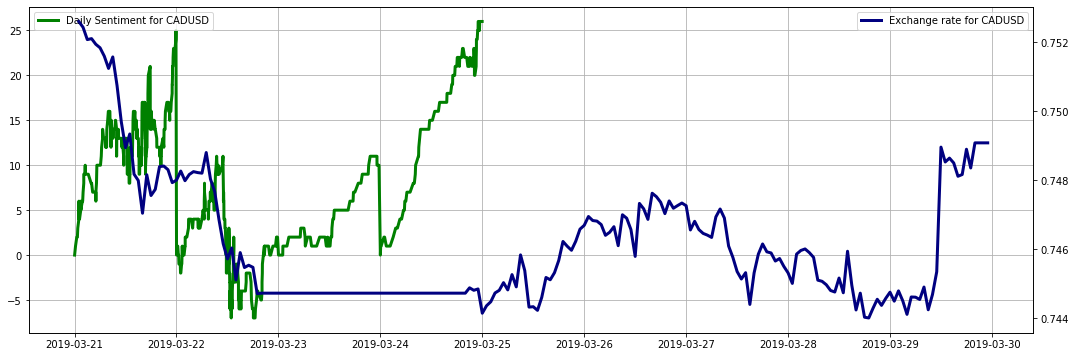

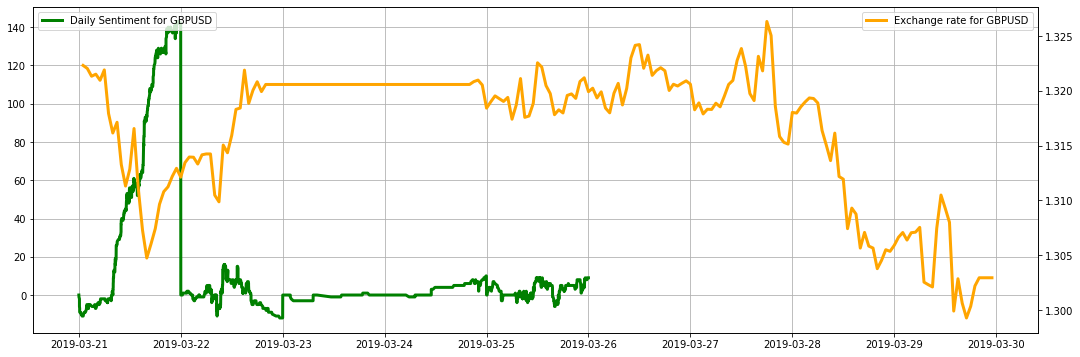

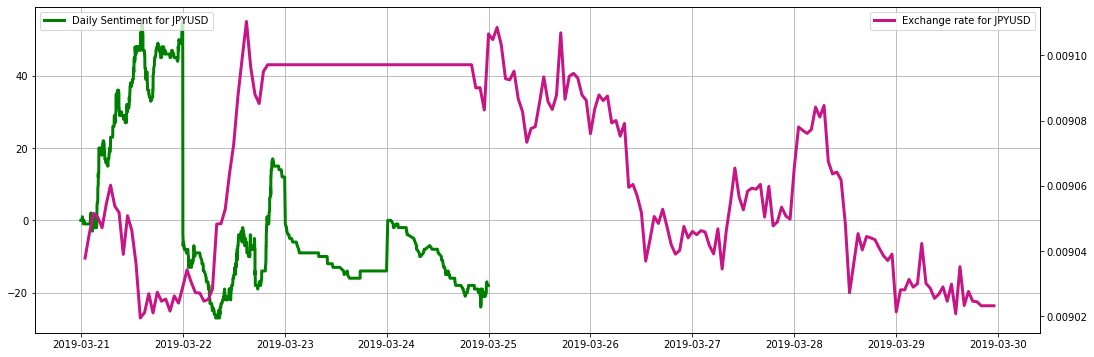

In [40]:
import matplotlib.pyplot as plt

np_sentiment_data_eur = convert_sentiment('EURUSD', date0, date1)
np_sentiment_data_cad = convert_sentiment('CADUSD', date0, date1)
np_sentiment_data_gbp = convert_sentiment('GBPUSD', date0, date1)
np_sentiment_data_jpy = convert_sentiment('JPYUSD', date0, date1)
np_price_data = convert_prices(date0, date1, period, decay)

sent_plot(np_sentiment_data_eur, np_price_data[2], 'EURUSD')
sent_plot(np_sentiment_data_cad, np_price_data[3], 'CADUSD')
sent_plot(np_sentiment_data_gbp, np_price_data[4], 'GBPUSD')
sent_plot(np_sentiment_data_jpy, np_price_data[5], 'JPYUSD')